In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# traigo mis funciones
import sys

sys.path.append('../src') #pongo los 2 puntos para que salga de la carpeta
import soporte_funciones as sf

# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product
from itertools import combinations

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../datos_1/df_stand.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353 entries, 0 to 352
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           353 non-null    float64
 1   propertyType    353 non-null    object 
 2   size_stand      353 non-null    float64
 3   exterior        353 non-null    bool   
 4   rooms           353 non-null    int64  
 5   bathrooms       353 non-null    int64  
 6   distance_stand  353 non-null    float64
 7   status          353 non-null    object 
 8   floor           353 non-null    object 
 9   hasLift         353 non-null    object 
dtypes: bool(1), float64(3), int64(2), object(4)
memory usage: 27.9+ KB


In [4]:
df['rooms'] = df['rooms'].astype('category')
df['bathrooms'] = df['bathrooms'].astype('category')

In [5]:
df_num, df_cat = sf.separar_dataframe(df)

In [6]:
df_num

,price,size_stand,distance_stand
0,750.0,0.011443,-0.714088
1,750.0,0.432212,-0.040932
2,400.0,0.305981,2.833801
3,590.0,0.432212,2.948728
4,684.0,-0.619710,-0.446614
...,...,...,...
348,640.0,0.390135,0.932143
349,700.0,-0.241018,-0.372706
350,700.0,-0.030634,-0.677725
351,700.0,0.642596,1.009599


In [7]:
cols_numericas = df_num.columns

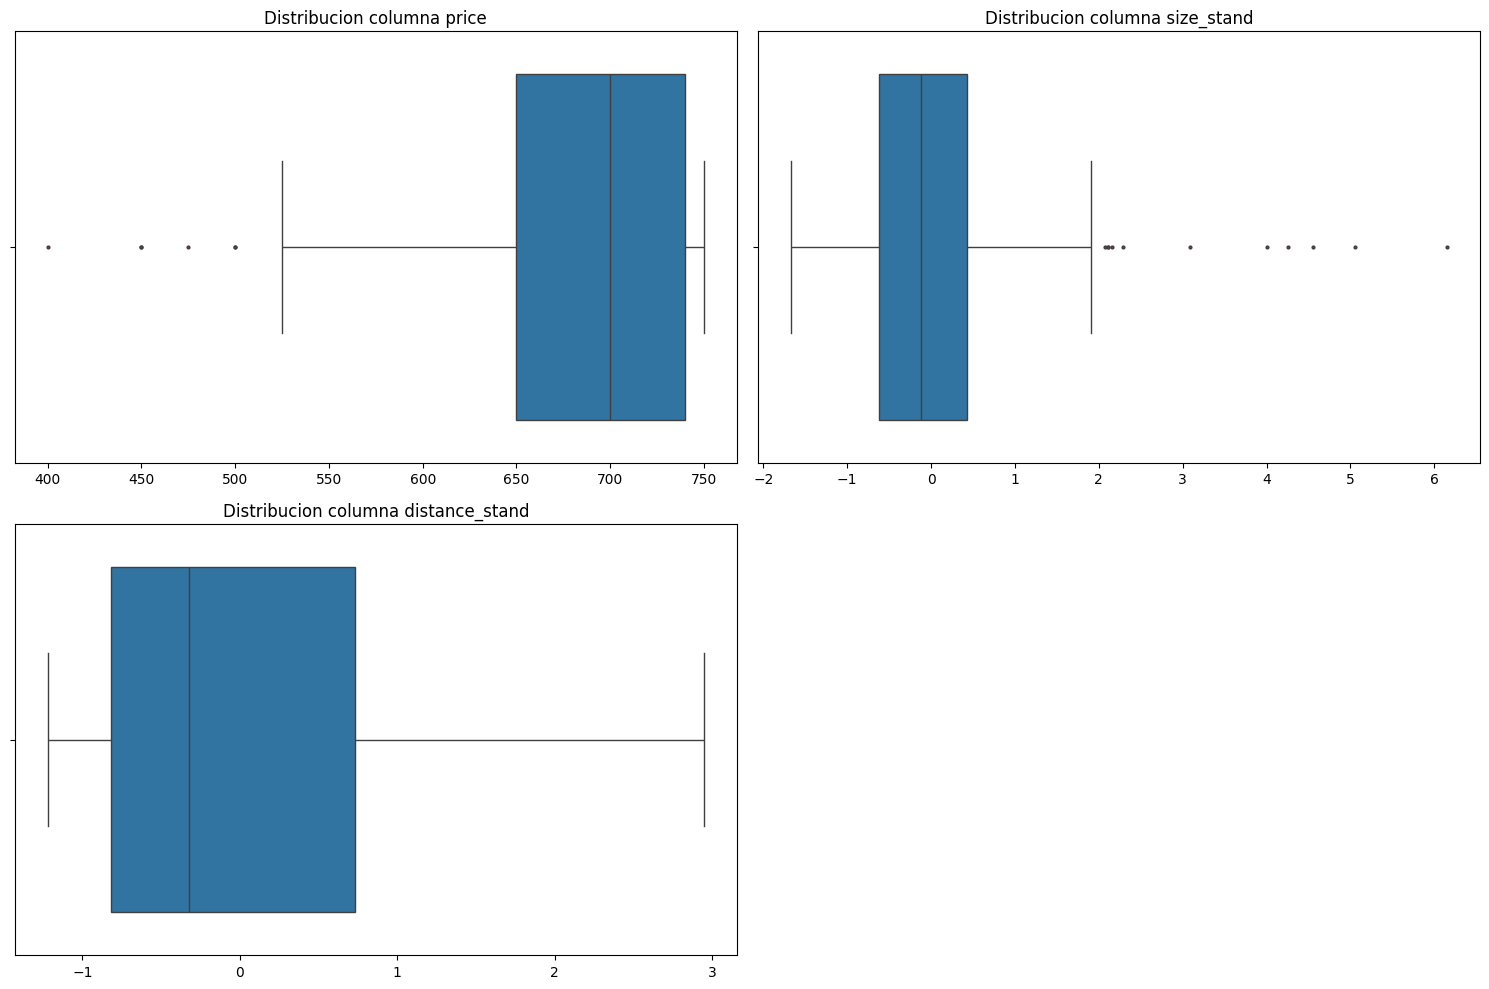

In [8]:
sf.plot_outliers_univariados(df,cols_numericas,'b',50)

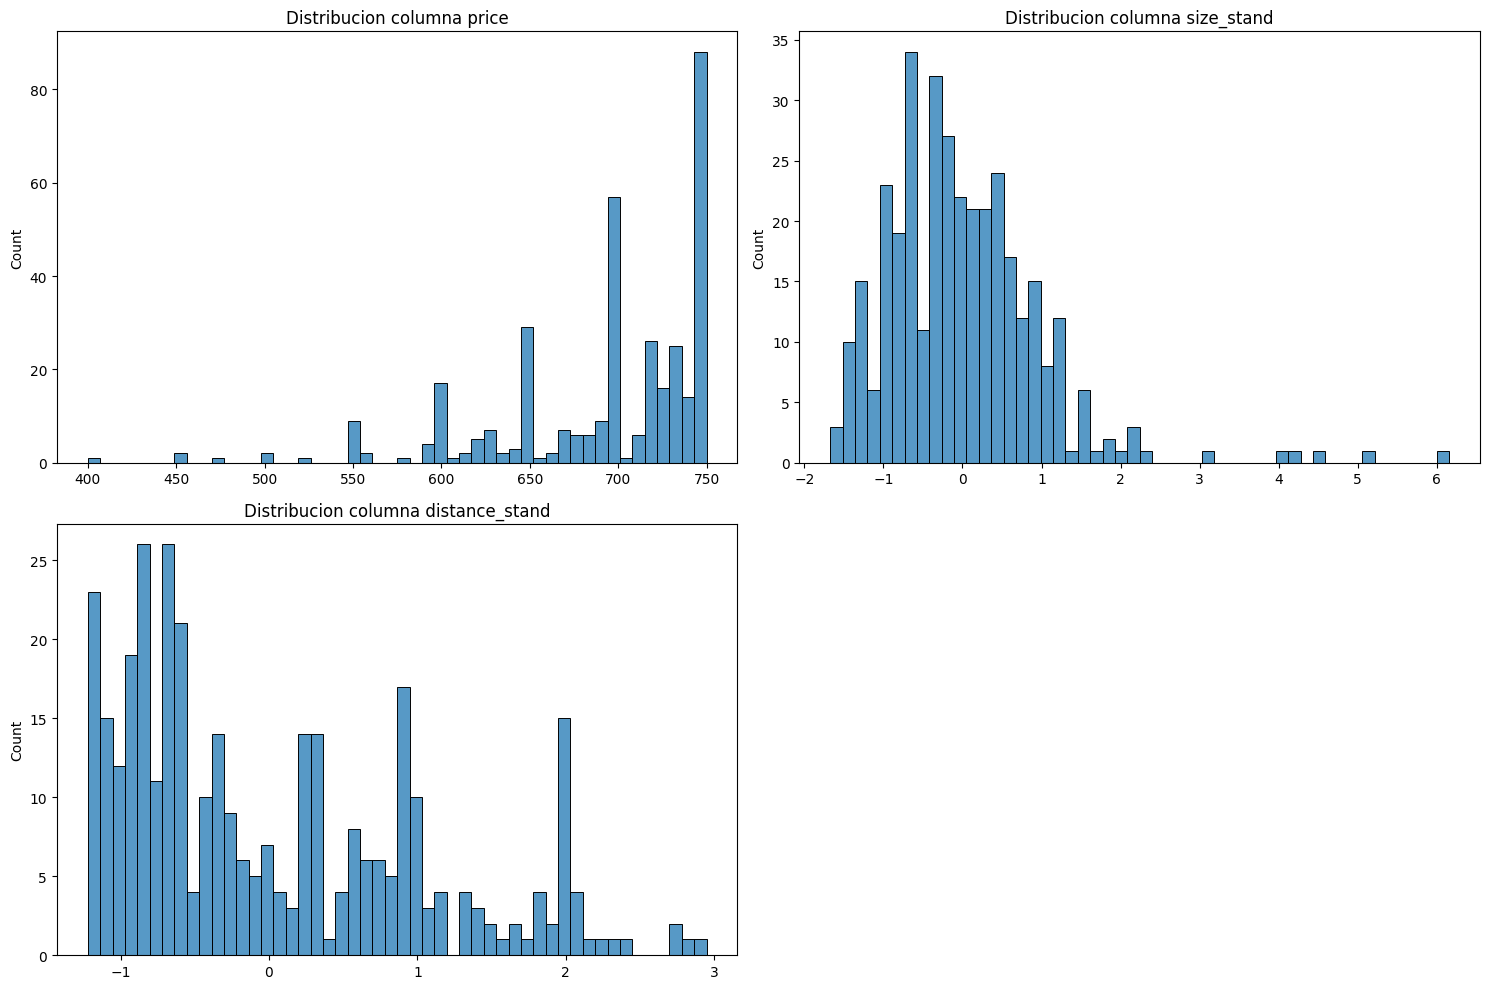

In [9]:
sf.plot_outliers_univariados(df, cols_numericas, 'h', 50)

In [10]:
diccionario_resultados_outliers = sf.identificar_outliers_iqr(df, cols_numericas)

La columna PRICE tiene 6 outliers
La columna SIZE_STAND tiene 11 outliers
La columna DISTANCE_STAND tiene 0 outliers


In [11]:
diccionario_resultados_outliers['size_stand'].head()

,price,propertyType,size_stand,exterior,rooms,bathrooms,distance_stand,status,floor,hasLift
18,650.0,chalet,6.154670,False,3,1,1.958285,good,Desconocido,Desconocido
55,720.0,flat,3.083057,False,3,2,0.203556,good,1,True
175,750.0,flat,2.157365,True,2,2,0.287072,good,6,True
191,660.0,flat,4.008748,False,3,2,1.804851,Desconocido,Desconocido,Desconocido
195,660.0,flat,4.555748,False,4,2,1.812390,good,3,True


# Isolation Forest: identificar outliers

In [12]:
contaminacion = [0.01, 0.05, 0.1]
estimadores = [10, 100, 150]

combinaciones = list(product(contaminacion, estimadores))
combinaciones

[(0.01, 10),
 (0.01, 100),
 (0.01, 150),
 (0.05, 10),
 (0.05, 100),
 (0.05, 150),
 (0.1, 10),
 (0.1, 100),
 (0.1, 150)]

In [13]:
for cont, esti in combinaciones:
    ifo = IsolationForest(random_state=42, #semilla de datos aleatorios
                        n_estimators=esti, #numero de arboles
                        contamination=cont,
                        n_jobs=-1) #nucleos del ordenador

    df[f'outliers_ifo_{cont}_{esti}'] = ifo.fit_predict(df[['price', 'size_stand', 'distance_stand']])

In [14]:
df.head()

,price,propertyType,size_stand,exterior,rooms,bathrooms,distance_stand,status,floor,hasLift,outliers_ifo_0.01_10,outliers_ifo_0.01_100,outliers_ifo_0.01_150,outliers_ifo_0.05_10,outliers_ifo_0.05_100,outliers_ifo_0.05_150,outliers_ifo_0.1_10,outliers_ifo_0.1_100,outliers_ifo_0.1_150
0,750.0,flat,0.011443,True,1,1,-0.714088,good,3,True,1,1,1,1,1,1,1,1,1
1,750.0,flat,0.432212,True,2,1,-0.040932,good,bj,False,1,1,1,1,1,1,1,1,1
2,400.0,penthouse,0.305981,True,2,2,2.833801,good,2,False,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,590.0,flat,0.432212,True,3,2,2.948728,good,Desconocido,False,1,1,1,-1,-1,-1,-1,-1,-1
4,684.0,studio,-0.619710,True,0,1,-0.446614,Desconocido,Desconocido,Desconocido,1,1,1,1,1,1,1,1,1


In [15]:
columnas_hue = df.filter(like='outlier').columns # se queda con todas las columnas de out

In [16]:
columnas_hue

Index(['outliers_ifo_0.01_10', 'outliers_ifo_0.01_100',
       'outliers_ifo_0.01_150', 'outliers_ifo_0.05_10',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_150', 'outliers_ifo_0.1_10',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_150'],
      dtype='object')

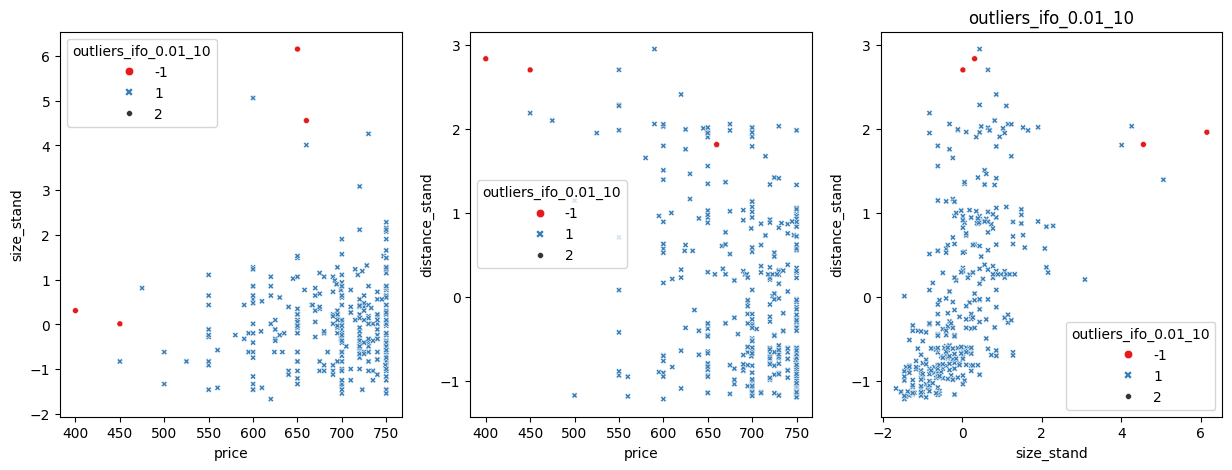

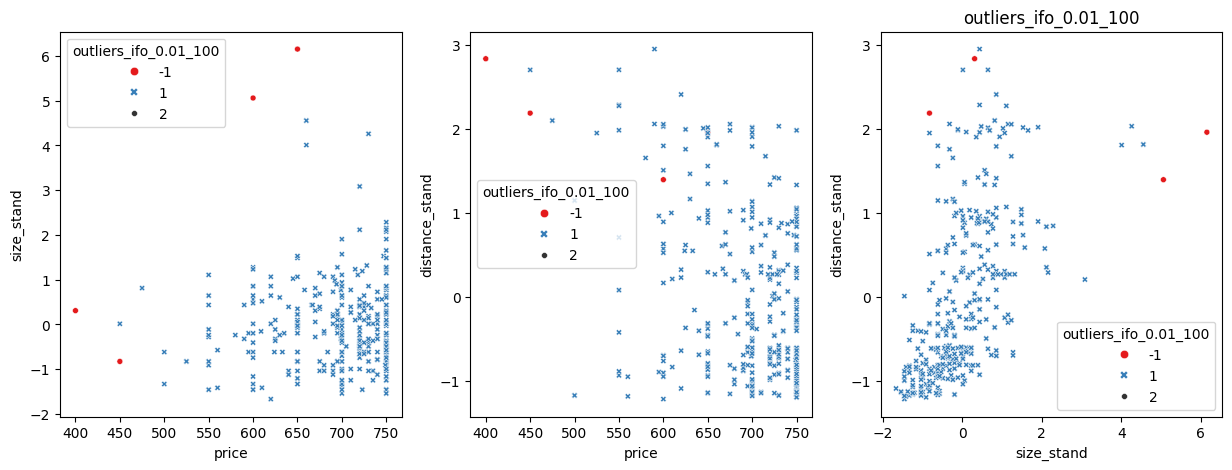

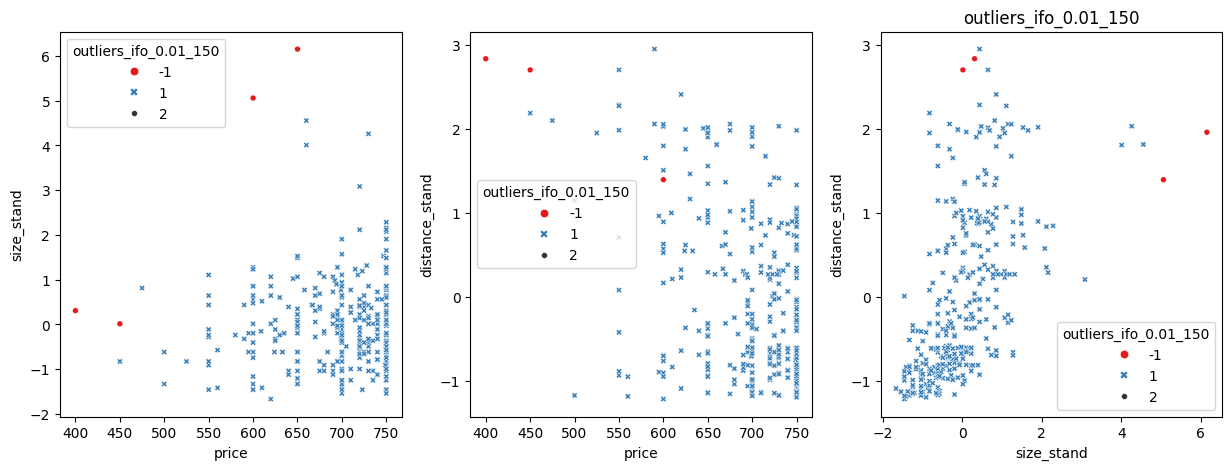

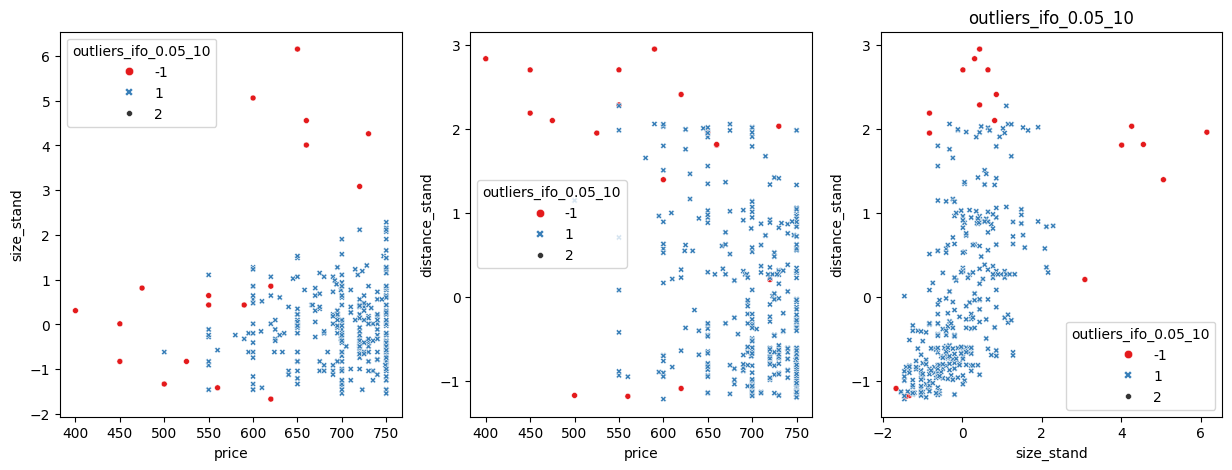

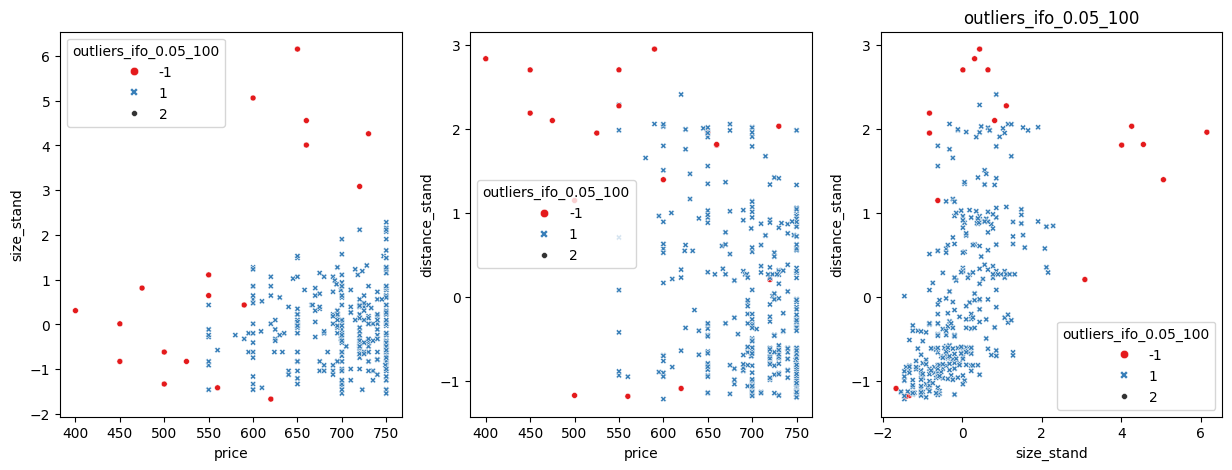

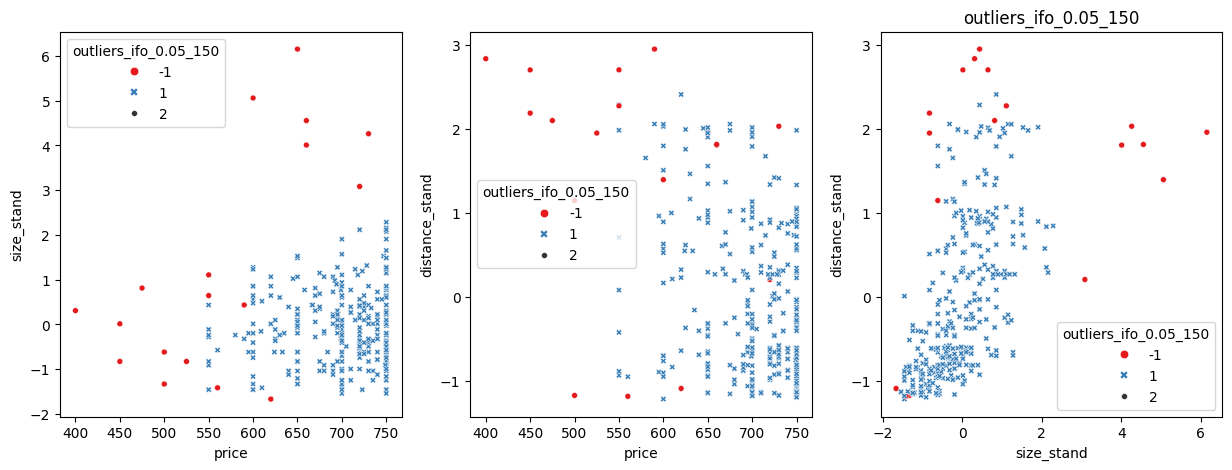

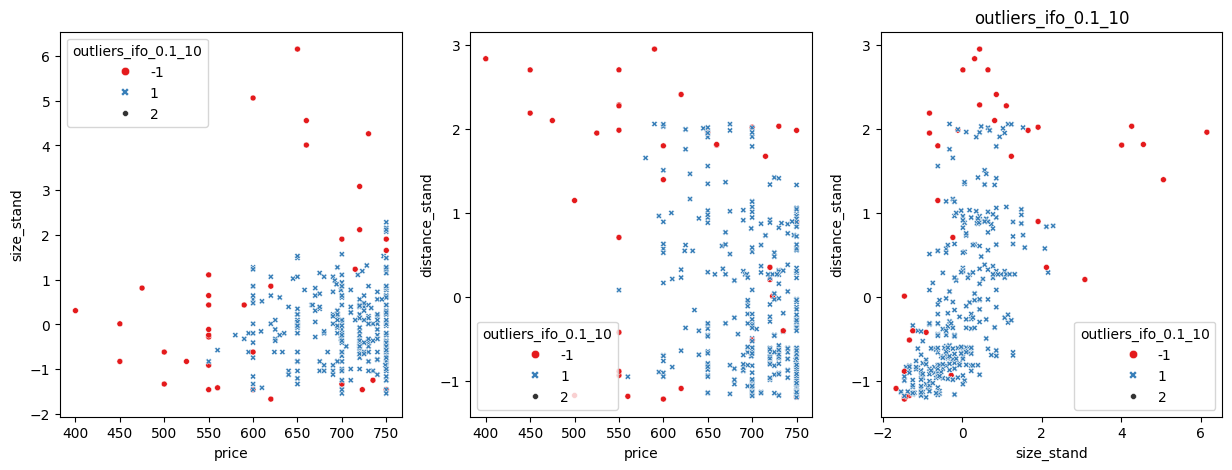

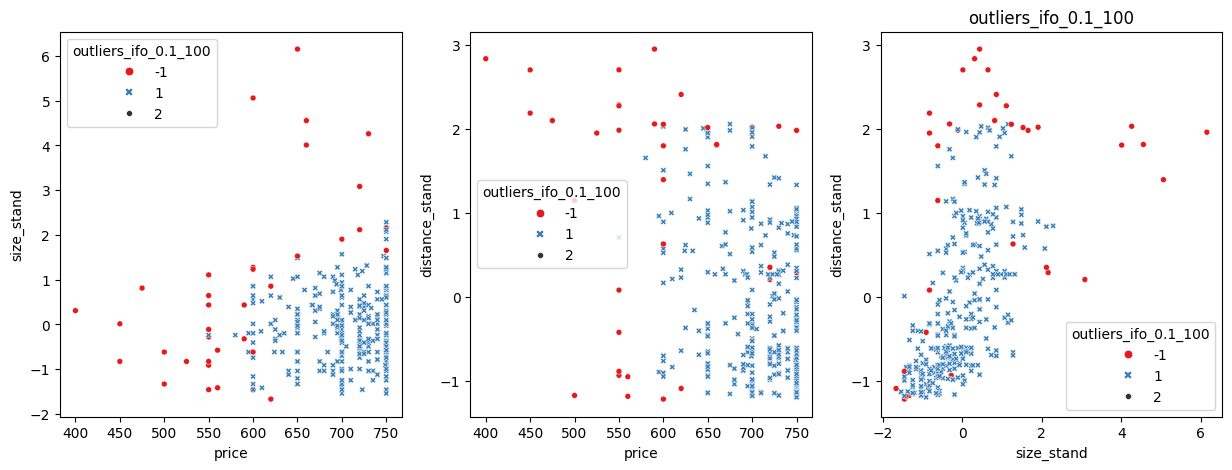

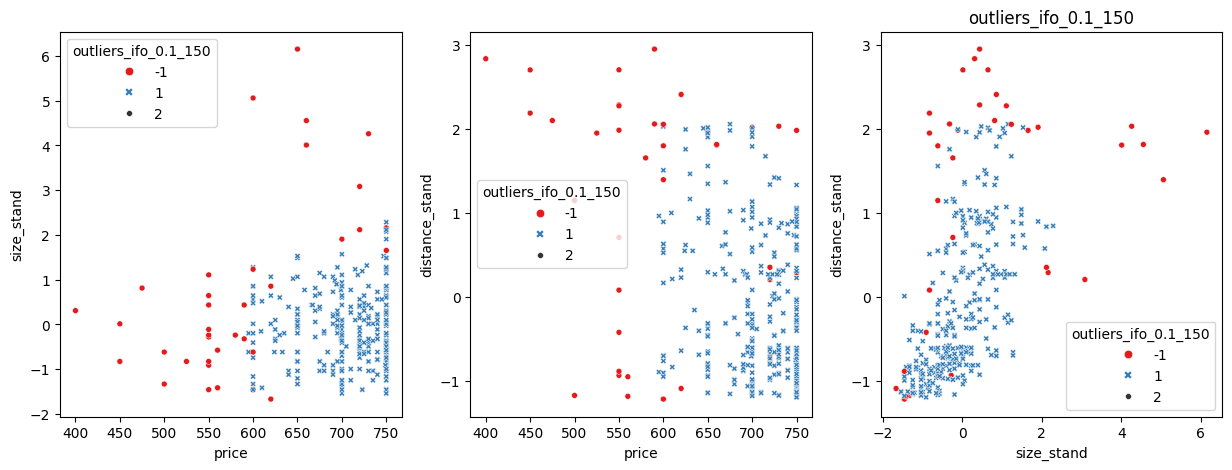

In [17]:
combinaciones_viz = list(combinations(['price', 'size_stand', 'distance_stand'], 2)) # hago combinaciones de 2
combinaciones_viz
for outlier in columnas_hue:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

    for indice, tupla in enumerate(combinaciones_viz):
        sns.scatterplot(x=tupla[0],
                        y=tupla[1], 
                        ax=axes[indice],
                        data=df,
                        style=outlier,
                        size=2,
                        hue=outlier, #aqui miro todos mis graficos para ver cual me muestra los mejores OUTL
                        palette='Set1')
        
    plt.title(f'{outlier}')

In [18]:
df.head()

,price,propertyType,size_stand,exterior,rooms,bathrooms,distance_stand,status,floor,hasLift,outliers_ifo_0.01_10,outliers_ifo_0.01_100,outliers_ifo_0.01_150,outliers_ifo_0.05_10,outliers_ifo_0.05_100,outliers_ifo_0.05_150,outliers_ifo_0.1_10,outliers_ifo_0.1_100,outliers_ifo_0.1_150
0,750.0,flat,0.011443,True,1,1,-0.714088,good,3,True,1,1,1,1,1,1,1,1,1
1,750.0,flat,0.432212,True,2,1,-0.040932,good,bj,False,1,1,1,1,1,1,1,1,1
2,400.0,penthouse,0.305981,True,2,2,2.833801,good,2,False,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,590.0,flat,0.432212,True,3,2,2.948728,good,Desconocido,False,1,1,1,-1,-1,-1,-1,-1,-1
4,684.0,studio,-0.619710,True,0,1,-0.446614,Desconocido,Desconocido,Desconocido,1,1,1,1,1,1,1,1,1


In [19]:
# Filtrar filas donde todas las columnas de 'columnas_hue' sean iguales a -1
filtered_df = df[(df[columnas_hue] == -1).all(axis=1)]


In [20]:
filtered_df

,price,propertyType,size_stand,exterior,rooms,bathrooms,distance_stand,status,floor,hasLift,outliers_ifo_0.01_10,outliers_ifo_0.01_100,outliers_ifo_0.01_150,outliers_ifo_0.05_10,outliers_ifo_0.05_100,outliers_ifo_0.05_150,outliers_ifo_0.1_10,outliers_ifo_0.1_100,outliers_ifo_0.1_150
2,400.0,penthouse,0.305981,True,2,2,2.833801,good,2,False,-1,-1,-1,-1,-1,-1,-1,-1,-1
18,650.0,chalet,6.154670,False,3,1,1.958285,good,Desconocido,Desconocido,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [21]:
df_result = df[~df.index.isin(filtered_df.index)]

In [22]:
fragmento = 0.6 * len(columnas_hue)
df_fragmento_60 = df_result[df_result[columnas_hue].eq(-1).sum(axis=1) >= fragmento]

In [23]:
df_fragmento_60

,price,propertyType,size_stand,exterior,rooms,bathrooms,distance_stand,status,floor,hasLift,outliers_ifo_0.01_10,outliers_ifo_0.01_100,outliers_ifo_0.01_150,outliers_ifo_0.05_10,outliers_ifo_0.05_100,outliers_ifo_0.05_150,outliers_ifo_0.1_10,outliers_ifo_0.1_100,outliers_ifo_0.1_150
3,590.0,flat,0.432212,True,3,2,2.948728,good,Desconocido,False,1,1,1,-1,-1,-1,-1,-1,-1
47,500.0,studio,-1.335018,False,0,1,-1.177345,good,1,False,1,1,1,-1,-1,-1,-1,-1,-1
55,720.0,flat,3.083057,False,3,2,0.203556,good,1,True,1,1,1,-1,-1,-1,-1,-1,-1
136,560.0,flat,-1.419172,False,1,1,-1.187987,good,bj,False,1,1,1,-1,-1,-1,-1,-1,-1
186,450.0,penthouse,0.011443,True,1,1,2.700545,good,Desconocido,False,-1,1,-1,-1,-1,-1,-1,-1,-1
188,550.0,penthouse,0.642596,True,2,2,2.701210,good,Desconocido,False,1,1,1,-1,-1,-1,-1,-1,-1
191,660.0,flat,4.008748,False,3,2,1.804851,Desconocido,Desconocido,Desconocido,1,1,1,-1,-1,-1,-1,-1,-1
195,660.0,flat,4.555748,False,4,2,1.812390,good,3,True,-1,1,1,-1,-1,-1,-1,-1,-1
225,730.0,flat,4.261210,True,4,1,2.029532,good,3,False,1,1,1,-1,-1,-1,-1,-1,-1
241,475.0,flat,0.810904,True,2,2,2.097380,good,2,True,1,1,1,-1,-1,-1,-1,-1,-1


<Axes: xlabel='price', ylabel='size_stand'>

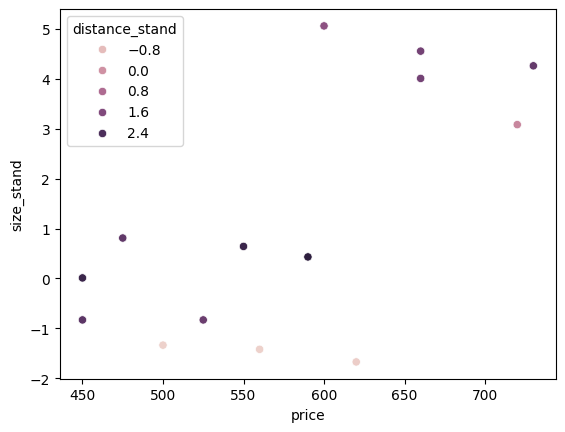

In [24]:
sns.scatterplot(x='price', y='size_stand', hue='distance_stand', data=df_fragmento_60)

df_elimino = df_fragmento_60[(df_fragmento_60['size_stand'] < 2) & (df['price'] < 550)]
df_elimino_1 = df_fragmento_60[(df_fragmento_60['size_stand'] > 2) & (df['price'] > 550)]

In [25]:
df_elimino_1 = df_fragmento_60[(df_fragmento_60['size_stand'] > 2) & (df['price'] > 550)]

In [26]:
df_elimino = df_fragmento_60[(df_fragmento_60['size_stand'] < 2) & (df['price'] < 550)]

In [27]:
eliminar_prueba_1 = df_elimino_1.index
df_result = df_result.drop(eliminar_prueba_1)

In [28]:
eliminar_prueba = df_elimino.index
df_result = df_result.drop(eliminar_prueba)

In [29]:
df_result.reset_index(inplace=True, drop=True)

In [30]:
df_result

,price,propertyType,size_stand,exterior,rooms,bathrooms,distance_stand,status,floor,hasLift,outliers_ifo_0.01_10,outliers_ifo_0.01_100,outliers_ifo_0.01_150,outliers_ifo_0.05_10,outliers_ifo_0.05_100,outliers_ifo_0.05_150,outliers_ifo_0.1_10,outliers_ifo_0.1_100,outliers_ifo_0.1_150
0,750.0,flat,0.011443,True,1,1,-0.714088,good,3,True,1,1,1,1,1,1,1,1,1
1,750.0,flat,0.432212,True,2,1,-0.040932,good,bj,False,1,1,1,1,1,1,1,1,1
2,590.0,flat,0.432212,True,3,2,2.948728,good,Desconocido,False,1,1,1,-1,-1,-1,-1,-1,-1
3,684.0,studio,-0.619710,True,0,1,-0.446614,Desconocido,Desconocido,Desconocido,1,1,1,1,1,1,1,1,1
4,600.0,flat,0.558443,True,2,1,1.505006,good,3,False,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,640.0,flat,0.390135,True,2,1,0.932143,good,2,True,1,1,1,1,1,1,1,1,1
337,700.0,flat,-0.241018,True,1,1,-0.372706,good,1,True,1,1,1,1,1,1,1,1,1
338,700.0,flat,-0.030634,True,1,1,-0.677725,good,6,True,1,1,1,1,1,1,1,1,1
339,700.0,flat,0.642596,True,2,1,1.009599,good,1,False,1,1,1,1,1,1,1,1,1


<Axes: xlabel='price', ylabel='size_stand'>

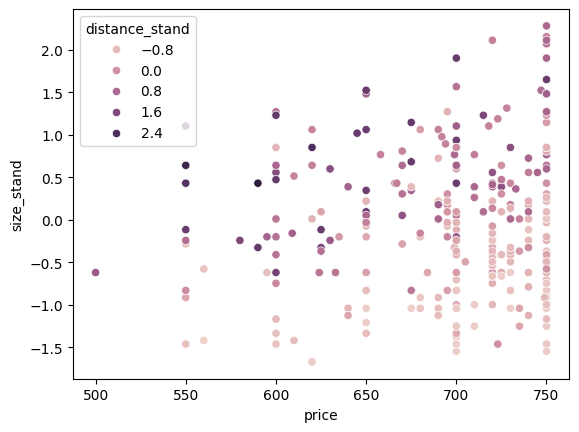

In [31]:
sns.scatterplot(x='price', y='size_stand', hue='distance_stand', data=df_result)

# Pendiente EDA

In [32]:
df_result.drop(columns=columnas_hue, inplace=True)

In [33]:
df_result.to_csv('..\\datos_1\\df_resultados_sin_out.csv')